# Problem Set 2
#### MACS 30200
Xiuyuan Zhang

In [15]:
# import library
import numpy as np
import pandas as pd
from pandas.core import datetools
from scipy.stats import gaussian_kde
from scipy.stats import pearsonr
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import LeaveOneOut
from sklearn.neighbors import KernelDensity
import statsmodels.api as sm

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

## Problem 1

In [16]:
# import data
bq_data = np.loadtxt('data/BQmat_orig.txt', delimiter=',')

### Part ( a ) : Plot the 2D empirical histogram of these data as a 3D surface plot

Text(0.5,0,'Density')

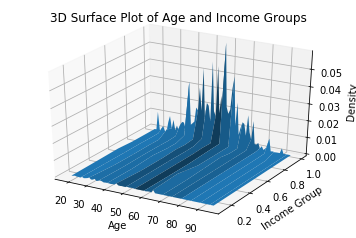

In [17]:
ages_vec = np.arange(18, 96)
abils_midpt = np.array([0.125, 0.375, 0.60, 0.75, 0.85, 0.94, 0.995])

# set up the plot
y_mat, x_mat = np.meshgrid(abils_midpt, ages_vec)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(x_mat, y_mat, bq_data, rstride=5)
plt.title("3D Surface Plot of Age and Income Groups")
plt.xlabel("Age")
plt.ylabel("Income Group")
ax.set_zlabel("Density")

### Part ( b ) : Fit a bivariate kernel density estimator to the data

In [18]:
prop_mat_inc = np.sum(bq_data, axis=0)
prop_mat_age = np.sum(bq_data, axis=1)
lrg_samp = 70000
age_probs = np.random.multinomial(lrg_samp, prop_mat_age)
income_probs = np.random.multinomial(lrg_samp, prop_mat_inc)
age_freq = np.array([])
inc_freq = np.array([])

# creating a distribution of age values
for age, num_s in zip(ages_vec, age_probs):
    vec_age_s = np.ones(num_s)
    vec_age_s *= age
    age_freq = np.append(age_freq, vec_age_s)

# creating a distribution of ability type values
for abil, num_j in zip(abils_midpt, income_probs):
    vec_abil_j = np.ones(num_j)
    vec_abil_j *= abil
    inc_freq = np.append(inc_freq, vec_abil_j)
    
    
# estimate bandwidth with cross validation
bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut(len(bq_data)))
grid.fit(bq_data[:, ]);

data = np.vstack((age_freq, inc_freq))
density = gaussian_kde(data, bw_method=grid.best_params_["bandwidth"])

coords = np.vstack([item.ravel() for item in [x_mat, y_mat]])
BQkde = density(coords).reshape(x_mat.shape)
BQkde_scaled = BQkde / np.sum(BQkde)

To determine the $\lambda$ parameter we use leave-one-out cross-validation by using a guassian kernel density estimator. We pick the $\lambda$ that the cross-valdiation determines as best fits for the data. For this one, it is about $\lambda=0.1$. Next we will plot the surface of our chosen kernel density estimator

Text(0.5,0,'Density')

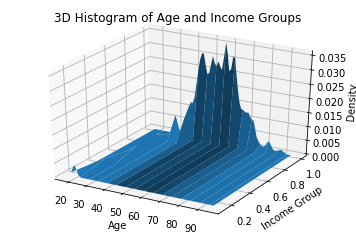

In [19]:
# Plot the surface of kernel density estimator.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(x_mat, y_mat, BQkde_scaled, rstride=5)
plt.title("3D Histogram of Age and Income Groups")
plt.xlabel("Age")
plt.ylabel("Income Group")
ax.set_zlabel("Density")

In [20]:
print('The density for a recipient with age = 61 and in the 6th lifetime income category is', BQkde_scaled[61, 5])

The density for a recipient with age = 61 and in the 6th lifetime income category is 1.97303464824e-07


## Problem 2

In [21]:
# import data
biden_df = pd.read_csv("data/biden.csv")

In [22]:
X = biden_df[['age', 'educ']]
y = biden_df['biden']

X['age*educ'] = X['age']*X["educ"]
X['const'] = 1

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [23]:
# Fit the OLS model and print the summary results
fit = sm.OLS(y, X, missing='drop', hasconst=True)
print(fit.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  biden   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     10.13
Date:                Mon, 30 Apr 2018   Prob (F-statistic):           1.29e-06
Time:                        08:39:56   Log-Likelihood:                -8333.3
No. Observations:                1826   AIC:                         1.667e+04
Df Residuals:                    1822   BIC:                         1.670e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.6674      0.169      3.950      0.0

### Part ( a ) : Evaluate the marginal eﬀect of age on Joe Biden thermometer rating, conditional on education.¶

From the table above, one can see that $age$ has a $0.6674 - 0.0477X_{education}$ marginal effect on $y$ (biden) conditional on $X_{education}$. When $X_{education} = 0$, $\beta_1 = 0.6674$. Thus, the effect of $age$ on biden feelings will show a decrease with the increase values of variable $education$. We also see that these are significant with $\alpha = 0.01$.

Nonetheless, several issues in this model specification could potentially bias our results. First, we are specifiedage and education in the model. But to evaluate $\hat\beta$ we must have that $\mathbb{E}[x_i'x_i]$ is full rank. Specifying age and education in the same model might potentially cause dependence which would bias our results. Moreover, we should consider that possibilities of unobserved effects in $e_i$ that will also affect $y_i$. For example, the income level of an individual is unobserved. Notice that the higher income level often allows individuals to obtain higher education levels. On the other hand, the income level might also have an impact on ones "like feelings" for Joe Biden. It may be the case that wealthier people tend to be democrats and thus tend to like Joe Biden more. Hence, an instance of endogenity may occur in this specification. We should be cautious when looking at our estimates for these reasons.


### Part ( b ) : Evaluate the marginal eﬀect of education on Joe Biden thermometer rating, conditional on age.
Similar to the previous part, we can interpret the marginal effect of education on biden rating as $1.7123 - 0.0477X_{age}$, which means if someone was of age 0, the expected rating of biden from them would be $1.7123$. This effect is statistically signifcant with an $\alpha=0.05$. One can also notice that the 95% confidence interval do not alter the sign of the estimates. Furthermore, one observes that, in both cases, the effects of $age$ and $education$ are discounted by each other. As in part (a), the effect of $education$ on biden feelings decreases with the increase of $age$. 
One should keep in mind that this may be influenced by a correlation between $age$ and $education$, as mentioned in part(a).

In [24]:
# Investigate the relation between education and age
fit2 = sm.OLS(X['age'], X['educ'], missing='drop')
print(fit2.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                    age   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                 1.126e+04
Date:                Mon, 30 Apr 2018   Prob (F-statistic):               0.00
Time:                        08:40:00   Log-Likelihood:                -10102.
No. Observations:                2272   AIC:                         2.021e+04
Df Residuals:                    2271   BIC:                         2.021e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
educ           3.4497      0.033    106.094      0.0

From the summary above one can see that reressing age on education yields $R^2 = 0.832$, suggesting that there is a strong correlation between variables $age$ and $education$.